
# Siemens Logistics - AI Agent

## Imports

In [1]:
# Imports
# Create_Flat_Tracking
import pandas as pd
import numpy as np
import os
import json
import glob
from datetime import datetime
from tqdm.autonotebook import tqdm
tqdm.pandas()

ModuleNotFoundError: No module named 'pandas'

## Prepare Dataset

### Mount drive

In [ ]:
# Mount my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import merged data

In [ ]:
# Initialize and import the tacking dataframe
df_merged = pd.read_json("/content/drive/MyDrive/Colab_Notebooks/Data/results/data_merged_export_06_02_2021.json", orient='records')

# formt columbs
df_merged[[c for c in df_merged.columns if c.endswith('_DATE')]] = \
    df_merged[[c for c in df_merged.columns if  c.endswith('_DATE')]].progress_apply(lambda x:pd.to_datetime(x,  unit='ms'))
df_merged[[c for c in df_merged.columns if c.endswith('_DURATION')]] = \
    df_merged[[c for c in df_merged.columns if  c.endswith('_DURATION')]].progress_apply(lambda x:pd.to_timedelta(x,  unit='s'))
    
df_merged['DELIVERY_DURATION_SECONDS'] = df_merged['DELIVERY_DURATION'].progress_apply(lambda x: x.total_seconds())

df_merged = df_merged.sort_values(['SHIPMENTID', 'STATUS_DATE'])

In [ ]:
df_merged_unique_shipments = df_merged['SHIPMENTID'].unique()
df_merged_unique_events = df_merged['reason_DE'].unique()
df_merged_unique_milestones = df_merged['MILESTONES'].unique()
df_merged_unique_reihenfolge = df_merged['REIHENFOLGE'].unique()
df_merged_unique_sender = df_merged['Sender'].unique()
df_merged_unique_receiver = df_merged['Receiver'].unique()
df_merged_unique_logistic_providers = df_merged['Logistics_Provider'].unique()

### Prepare Datasets

#### Delivery Time Prediction

In [ ]:
# DEFINE CONSTANTS
BATCH_SIZE = 32

In [ ]:
df_delivery_time = df_merged[['SHIPMENTID', 'reason_DE', 'MILESTONES', 'REIHENFOLGE', 'EVENT_DURATION_SECONDS', 'Shipment_Distance', 'Qty__INT', 'Volume__FLOAT','Weight__FLOAT','Logistics_Provider', 'Sender', 'Receiver', 'DELIVERED', 'DELIVERY_DURATION_SECONDS']].copy()

# Convert fields to category
continuous_features = ["EVENT_DURATION_SECONDS", 'Shipment_Distance','Qty__INT', 'Volume__FLOAT','Weight__FLOAT' ]
categorical_int_features = [ 'SHIPMENTID', 'REIHENFOLGE','DELIVERED']
categorical_string_features = [ 'reason_DE', 'MILESTONES', 'Logistics_Provider', 'Sender', 'Receiver']
target_features = ["DELIVERY_DURATION_SECONDS"]

for cat in categorical_string_features:
    df_delivery_time[[cat]]= df_delivery_time[[cat]].astype(pd.StringDtype())

for cat in continuous_features:
    df_delivery_time[[cat]] = df_delivery_time[[cat]].astype("float64")

for cat in categorical_int_features:
    df_delivery_time[[cat]] = df_delivery_time[[cat]].astype("int64")

print(df_delivery_time.dtypes)
df_delivery_time.head()


SHIPMENTID                     int64
reason_DE                     string
MILESTONES                    string
REIHENFOLGE                    int64
EVENT_DURATION_SECONDS       float64
Shipment_Distance            float64
Qty__INT                     float64
Volume__FLOAT                float64
Weight__FLOAT                float64
Logistics_Provider            string
Sender                        string
Receiver                      string
DELIVERED                      int64
DELIVERY_DURATION_SECONDS    float64
dtype: object


,SHIPMENTID,reason_DE,MILESTONES,REIHENFOLGE,EVENT_DURATION_SECONDS,Shipment_Distance,Qty__INT,Volume__FLOAT,Weight__FLOAT,Logistics_Provider,Sender,Receiver,DELIVERED,DELIVERY_DURATION_SECONDS
0,297975316,Eingang Versandpartner,Ankunft Zustellterminal,490,797280.0,-1.0,1.0,0.000,1775.0,Heppner GmbH & Co. KG - Neu-Ulm,SCHEPPACH FABRIKATION VON,PROBOIS MACHINOUTILS,1,1119660.0
1,297975316,Sendung auf dem Weg zum Empfänger/in Zustellung,In Zustellung,500,322380.0,-1.0,1.0,0.000,1775.0,Heppner GmbH & Co. KG - Neu-Ulm,SCHEPPACH FABRIKATION VON,PROBOIS MACHINOUTILS,1,1119660.0
2,297975316,Reine Quittung,Zustellung,600,0.0,-1.0,1.0,0.000,1775.0,Heppner GmbH & Co. KG - Neu-Ulm,SCHEPPACH FABRIKATION VON,PROBOIS MACHINOUTILS,1,1119660.0
3,298220199,Eingang Versandpartner,Ankunft Zustellterminal,490,224760.0,-1.0,1.0,0.185,22.0,Heppner GmbH & Co. KG - MÜNCHEN,MATRIUM GMBH,J GARRAIO C LDA,1,656640.0
4,298220199,Verladen an,Abfahrt von Abholterminal,410,431880.0,-1.0,1.0,0.185,22.0,Heppner GmbH & Co. KG - MÜNCHEN,MATRIUM GMBH,J GARRAIO C LDA,1,656640.0


In [ ]:
# Verify there are NaN columns
# df_delivery_time.isna().sum()
# Drop all NaN values
# df_delivery_time = df_delivery_time.dropna()

## AI AGENTS

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
import pandas as pd
import numpy as np
import glob
import cv2
import os

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

### Delivery Time Prediction - MLP with Keras

#### Convert Panda Dataframe to Keras Dataset

In [ ]:
# Split Data in Training and tests
val_dataframe = df_delivery_time.sample(frac=0.2, random_state=1234)
train_dataframe = df_delivery_time.drop(val_dataframe.index)
print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 159977 samples for training and 39994 for validation


In [ ]:
# Let's generate tf.data.Dataset objects for each dataframe:
def dataframe_to_dataset(dataframe, target):
    dataframe = dataframe.copy()
    labels = dataframe.pop(target)
    n_labels = keras.utils.normalize(labels.to_numpy())
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), n_labels[0]))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_dataframe,"DELIVERY_DURATION_SECONDS")
val_ds = dataframe_to_dataset(val_dataframe, "DELIVERY_DURATION_SECONDS")
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'SHIPMENTID': <tf.Tensor: shape=(), dtype=int64, numpy=310425996>, 'reason_DE': <tf.Tensor: shape=(), dtype=string, numpy=b'Ablieferbeleg (POD) archiviert (FR)'>, 'MILESTONES': <tf.Tensor: shape=(), dtype=string, numpy=b'Archiviert'>, 'REIHENFOLGE': <tf.Tensor: shape=(), dtype=int64, numpy=650>, 'EVENT_DURATION_SECONDS': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'Shipment_Distance': <tf.Tensor: shape=(), dtype=float64, numpy=6596.6821190354>, 'Qty__INT': <tf.Tensor: shape=(), dtype=float64, numpy=1.0>, 'Volume__FLOAT': <tf.Tensor: shape=(), dtype=float64, numpy=0.657>, 'Weight__FLOAT': <tf.Tensor: shape=(), dtype=float64, numpy=97.0>, 'Logistics_Provider': <tf.Tensor: shape=(), dtype=string, numpy=b'Heppner GmbH & Co. KG - Singen'>, 'Sender': <tf.Tensor: shape=(), dtype=string, numpy=b'HSM GMBH CO KG'>, 'Receiver': <tf.Tensor: shape=(), dtype=string, numpy=b'COUR DES COMPTES'>, 'DELIVERED': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
Target: tf.Tensor(0.0070713784758240

In [ ]:
# Let's batch the datasets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

#### Feature preprocessing with Keras layers

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature

In [ ]:
# Overwrite the values to select only the features needed for the model
continuous_features = ['Shipment_Distance','Qty__INT', 'Volume__FLOAT','Weight__FLOAT' ] # "EVENT_DURATION_SECONDS"
categorical_int_features = [ 'REIHENFOLGE']
categorical_string_features = [ 'reason_DE', 'MILESTONES', 'Logistics_Provider'] # , 'Sender', 'Receiver'
target_features = ["DELIVERY_DURATION_SECONDS"]

# Build Model
all_inputs = []
all_features = []

# Categorical features encoded as integers
for cat in categorical_int_features:
  if not cat in target_features:
    _tmp = keras.Input(shape=(1,), name=cat, dtype="int64")
    _tmp_layer = encode_integer_categorical_feature(_tmp, cat, train_ds)
    all_inputs.append(_tmp)
    all_features.append(_tmp_layer)

# Categorical feature encoded as string
for cat in categorical_string_features:
  if not cat in target_features:
    _tmp_str = keras.Input(shape=(1,), name=cat, dtype="string")
    _tmp_str_layer = encode_string_categorical_feature(_tmp_str, cat, train_ds)
    all_inputs.append(_tmp_str)
    all_features.append(_tmp_str_layer)

# Numerical features
for cat in continuous_features:
  if not cat in target_features:
    _tmp_cont = keras.Input(shape=(1,), name=cat)
    _tmp_cont_layer = encode_numerical_feature(_tmp_cont, cat, train_ds)
    all_inputs.append(_tmp_cont)
    all_features.append(_tmp_cont_layer)

all_features_layers = layers.concatenate(all_features)

#### Build Keras Model

In [ ]:
# Build Keras Model
x = layers.Dense(64, activation="relu")(all_features_layers)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1, activation="linear")(x)
model_delivery_time = keras.Model(all_inputs, output)
model_delivery_time.compile("adam", "mse", metrics=["accuracy"])

#### Visualize the keras model

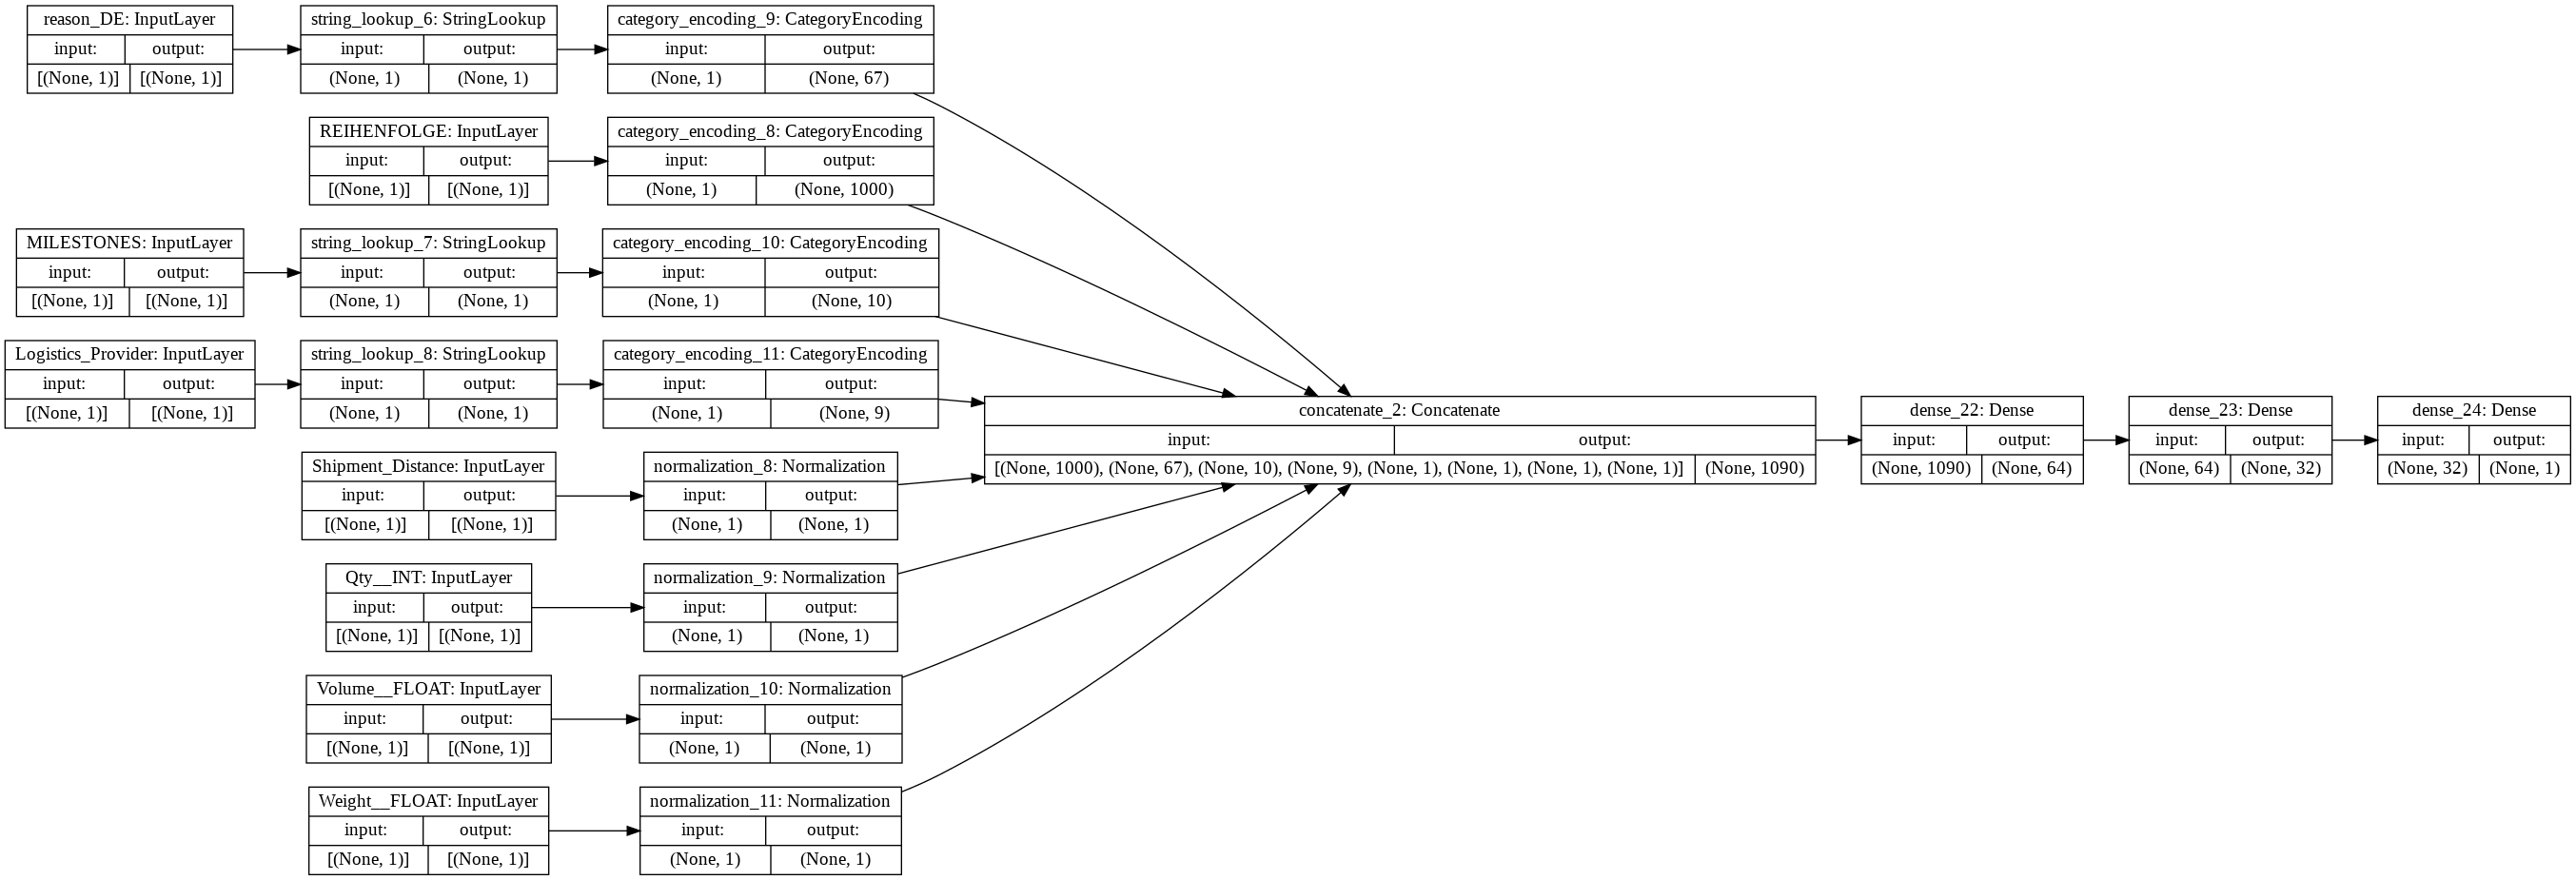

In [ ]:
# Plot the model
keras.utils.plot_model(model_delivery_time, show_shapes=True, rankdir="LR")

In [ ]:
# Model Summry
model_delivery_time.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reason_DE (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
MILESTONES (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Logistics_Provider (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
REIHENFOLGE (InputLayer)        [(None, 1)]          0                                            
____________________________________________________________________________________________

#### Train

In [ ]:
# Train
history_delivery_time = model_delivery_time.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['SHIPMENTID', 'EVENT_DURATION_SECONDS', 'Sender', 'Receiver', 'DELIVERED'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


5000/5000 [==============================] - 25s 5ms/step - loss: 1.5182e-04 - accuracy: 0.0089 - val_loss: 1.5543e-05 - val_accuracy: 0.0083
Epoch 2/50
2116/5000 [===========>..................] - ETA: 11s - loss: 1.8786e-06 - accuracy: 0.0096

KeyboardInterrupt: ignored

### Delivery Time Prediction - Scikit

In [ ]:
# Constants
DEBUG = False

#### Convert Panda Dataframe to Numpy Array Dataset

In [ ]:
# Override to determine features and targets
continuous_features = ['Shipment_Distance','Qty__INT', 'Volume__FLOAT','Weight__FLOAT' ] # "EVENT_DURATION_SECONDS", 
categorical_int_features = [ 'REIHENFOLGE']
categorical_string_features = [ 'reason_DE','MILESTONES', 'Logistics_Provider'] # , 'Sender', 'Receiver'
target_continous_features = ["DELIVERY_DURATION_SECONDS"]
target_categorical_features = ['DELIVERED']

features_dict = {}
target_dict = {}
normalizer_dict = {}

# Normalize target continous feature values
for cat in target_continous_features:
    sc = StandardScaler()
    X = df_delivery_time[[cat]].values
    X = sc.fit_transform(X)
    target_dict[cat] = np.copy(X)
    normalizer_dict[cat] = sc
if DEBUG: 
    print(target_dict)

# Normalize target string category feature values
for cat in target_categorical_features:
    sc = OneHotEncoder()
    X = df_delivery_time[[cat]].values
    X = sc.fit_transform(X).toarray()
    target_dict[cat] = np.copy(X)
    normalizer_dict[cat] = sc
if DEBUG: 
    print(target_dict)

# Normalize Continous feature values
for cat in continuous_features:
    sc = StandardScaler()
    X = df_delivery_time[[cat]].values
    X = sc.fit_transform(X)
    features_dict[cat] = np.copy(X)
    normalizer_dict[cat] = sc
if DEBUG:
    print(features_dict)

# Normalize string category feature values
for cat in categorical_string_features:
    sc = LabelBinarizer()
    X = df_delivery_time[[cat]].values
    X = sc.fit_transform(X)
    features_dict[cat] = np.copy(X)
    normalizer_dict[cat] = sc
if DEBUG:
    print(features_dict)

# Normalize string category feature values
for cat in categorical_int_features:
    sc = OneHotEncoder()
    X = df_delivery_time[[cat]].values
    X = sc.fit_transform(X).toarray()
    features_dict[cat] = np.copy(X)
    normalizer_dict[cat] = sc
if DEBUG:
    print(features_dict)


In [ ]:
# Build the dataset
d_Y = target_dict["DELIVERY_DURATION_SECONDS"]

df_d_X = np.array(list(features_dict.items()))
df_d_X.T.reshape((199971, 8, ))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


ValueError: ignored